In [45]:
import math as mth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer,FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
from xgboost import XGBRegressor
import tensorflow as tf
import scipy
from scipy.stats import linregress
from scipy.stats import pearsonr
import statsmodels
from datetime import datetime, timedelta
import random
import sys
import os
from io import StringIO
import json # library to handle JSON files
from matplotlib import cm,colors
from matplotlib.colors import Normalize
from geopy.geocoders import Nominatim # convert an place into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import camelot
import requests
from IPython import get_ipython

In [46]:
import warnings

# Customize how warnings are displayed
warnings.filterwarnings('always', module='.*')
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'

General Classes and Functions

In [70]:
# Class to create Plots grid

from itertools import product,cycle,combinations
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class Plotsgrid:

    """ Creates a nxn grid of plots for an input df. Shows blank for grid values exceeding number of columns of df"""


    def __init__(self,df):
        self.df=df 

    def figure_params(self,size_fac1,size_fac2):
        df=self.df
        n_data_cols=len(df.columns)
        self.n_data_cols=n_data_cols 

        n_cols=int(n_data_cols**.5)
        n_rows=0
        while n_rows*n_cols<n_data_cols:
            n_rows+=1
        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(int(size_fac1*n_data_cols),int(size_fac2*n_rows)))
        
        # Flatten the axs array for easier iteration
        if n_rows == 1 and n_cols == 1:  # Only one subplot
            self.axs = [axs]
        else:
            self.axs = axs.flatten()

    # Loop through the axes and Hist plot
    def histplots(self,bins=-1,density=False):
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            if bins==-1:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax)  # Plot the histogram on the current axis
            else:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins)  # Plot the histogram on the current axis
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Box plot
    def boxplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(df.columns)
        for i,ax in enumerate(self.axs):
            try:
                if i==self.n_data_cols:
                    ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                    break
                col = next(cycler)  # Get the next column name
                sns.boxplot(data=df, y=col, ax=ax)  # Plot the boxplot on the current axis
            except Exception as E:
                print(E)
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Line plot
    def lineplots(self):
        # Initialize figure 
        self.figure_params(5,5)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            print(col)
            sns.lineplot(data=self.df,x=self.df.index,y=col, ax=ax)  # Plot the Line on the current axis
        plt.tight_layout()
        plt.show()

    def scatterplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Get all numeric combinations
        col_combinations = list(combinations(df.columns, 2))
        num_combs = len(col_combinations)
        
        # Calculate grid size based on the number of combinations
        n_cols = int(np.ceil(np.sqrt(num_combs)))
        n_rows = int(np.ceil(num_combs / n_cols))

        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(int(2*n_cols),int(2.5*n_rows)))
        
        plt.suptitle('Pairwise Scatter with higher correlations shown brighter')
        axs = axs.flatten()  # Flatten the axes array for easier iteration

        # Iterate through each combination and plot scatterplots
        for i, (col_x, col_y) in enumerate(col_combinations):
            ax = axs[i]

            df_x_y=df[[col_x,col_y]].dropna()

            x = df_x_y[col_x]
            y = df_x_y[col_y]

            # Calculate Pearson correlation and p-value
            if len(x) > 1 and len(y) > 1:  # Ensure there are enough data points
                corr, p_value = pearsonr(x, y)
                corr_array=np.array([corr]*x.shape[0])
                # Scatter plot with colored points
                sns.scatterplot(x=x, y=y, ax=ax,hue=corr_array, palette='coolwarm',hue_norm=(-1,1),legend=False)

                # Add correlation coefficient and p-value as the legend
                ax.text(0.05, 0.95, f"r = {corr:.2f}\np = {p_value:.2e}", 
                        transform=ax.transAxes, fontsize=7, verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="black"))
                
                # Set plot labels
                ax.set_xlabel(col_x)
                ax.set_ylabel(col_y)

        # Hide any extra subplots
        for j in range(i + 1, len(axs)):
            axs[j].set_visible(False)
        plt.tight_layout()
        plt.show()

In [48]:
def mape(y_true, y_pred):
    """Compute the mean absolute percentage error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
def basic_eda(df):
    cols=df.columns.tolist()
    print('\nCOLUMNS LIST: ')
    print(cols)
    print('\nFIRST FEW: ')
    print(df.head(3))
    print('\nINFO: ')
    print(df.info())
    print('\nDESCRIPTION: ')
    print(df.describe())
    return cols

## Data Extraction

In [50]:
df_logins=pd.read_json('logins.json')
df_data=pd.read_json('ultimate_data_challenge.json')

In [51]:
logins_cols=basic_eda(df_logins)


COLUMNS LIST: 
['login_time']

FIRST FEW: 
           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37

INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None

DESCRIPTION: 
                          login_time
count                          93142
mean   1970-02-26 19:09:39.779648278
min              1970-01-01 20:12:16
25%       1970-02-04 10:37:19.750000
50%       1970-03-01 06:33:05.500000
75%       1970-03-22 04:01:10.750000
max              1970-04-13 18:57:38


In [52]:
data_cols=basic_eda(df_data)


COLUMNS LIST: 
['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

FIRST FEW: 
             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0        1.1     2014-06-17   iPhone       15.4                 True   
1        1.0     2014-05-05  Android        0.0                False   
2        1.0     2014-01-07   iPhone        0.0                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0   

## Exploratory Data Analysis (EDA)

In [ ]:
# Create a dummy column called 'num'
df_logins['num']=1

<b> Time Plot of original data: </b>

### Aggregation based on 15 minute intervals

In [147]:
# Create Aggregation
df_logins_agg=df_logins.copy()
df_logins_agg['login_time'] = pd.to_datetime(df_logins_agg['login_time'])  # Ensure datetime format

# Set 'login_time' as the index
df_logins_agg.set_index('login_time', inplace=True)

# Resample based on 15-minute intervals and aggregate (e.g., count the number of logins)
df_logins_agg = df_logins_agg.resample('15min').sum()  # Replace `.count()` with appropriate aggregation

cols_logins_agg=basic_eda(df_logins_agg)



COLUMNS LIST: 
['num']

FIRST FEW: 
                     num
login_time              
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9

INFO: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   num     9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB
None

DESCRIPTION: 
               num
count  9788.000000
mean      9.515938
std       8.328818
min       0.000000
25%       3.000000
50%       7.000000
75%      13.000000
max      73.000000


<b> Time Plot: </b>

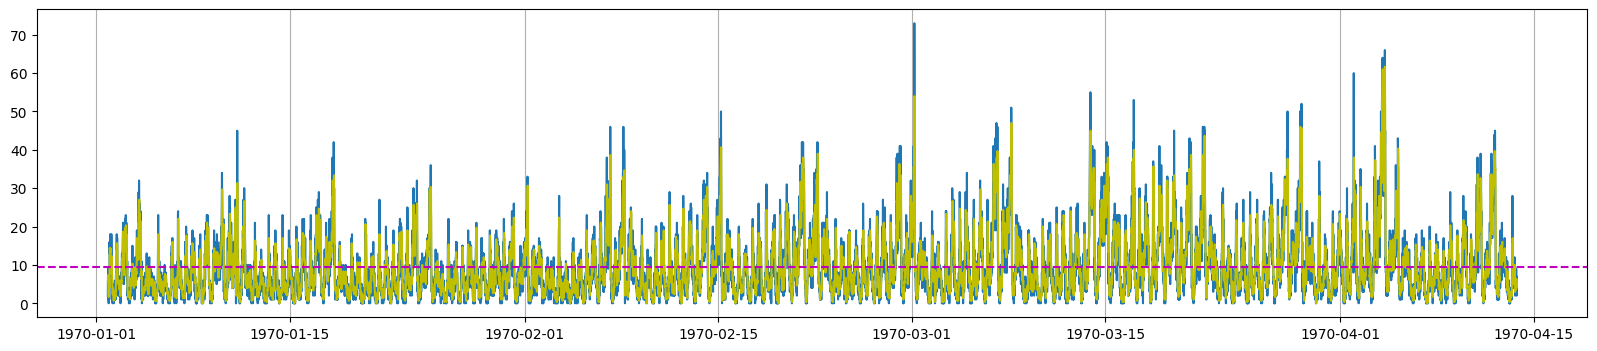

In [148]:
mean_logins=df_logins_agg.mean().values[0]
rolling_logins=df_logins_agg.rolling(3).mean().interpolate().bfill()
plt.figure(figsize=(20,4))
plt.plot(df_logins_agg)
plt.plot(rolling_logins,'-y')
plt.axhline(mean_logins,linestyle='--',color='m')
plt.grid(axis='x')
plt.show()

<li> There seems to be significant fluctuations in login with variation around mean
<li> Possible seasonality effect
<br>
<p> Let's look at the autocorrelation function to explore seasonality </p>

[ 1.          0.83065749  0.7838773  ... -0.05604951 -0.04703516
 -0.04032371]


array([ 48,  96, 151, 193, 247, 288, 329, 384, 426, 480, 522, 576, 622,
       672, 719, 768, 823, 864, 918, 960], dtype=int64)

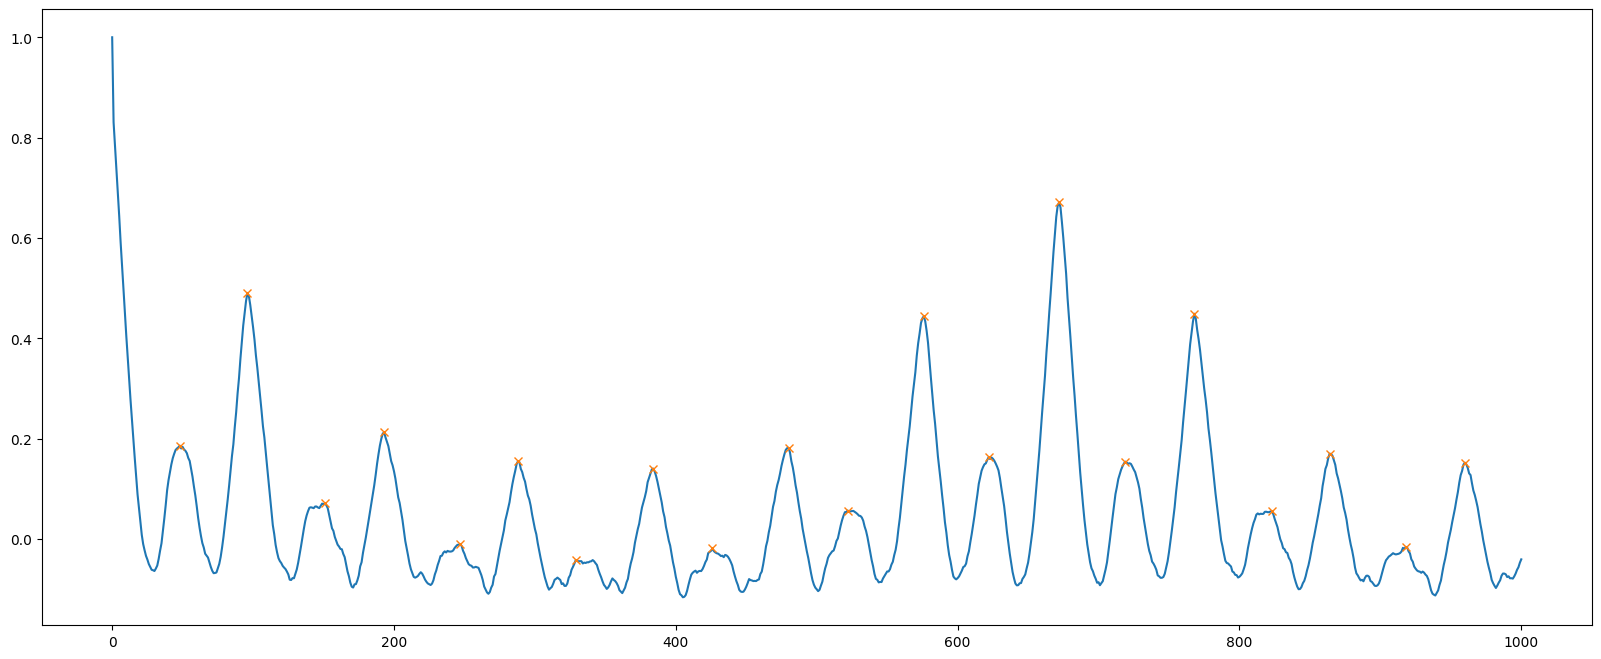

In [149]:
from statsmodels.tsa.stattools import acf

# Assuming 'df_logins_agg' is your time series data (as a pandas Series or DataFrame column)
# Calculate ACF values up to 1000 lags
acf_values = acf(df_logins_agg, nlags=1000)  # Adjust 'nlags' as needed

# Display the ACF values
print(acf_values)

# Determining the peaks of the ACF plots
peaks1, _ = scipy.signal.find_peaks(acf_values,prominence=.05)
plt.figure(figsize=(20,8))
plt.plot(acf_values)
plt.plot(peaks1,acf_values[peaks1],'x')
peaks1

<b> Plot a distribution of the difference of the peaks indices:

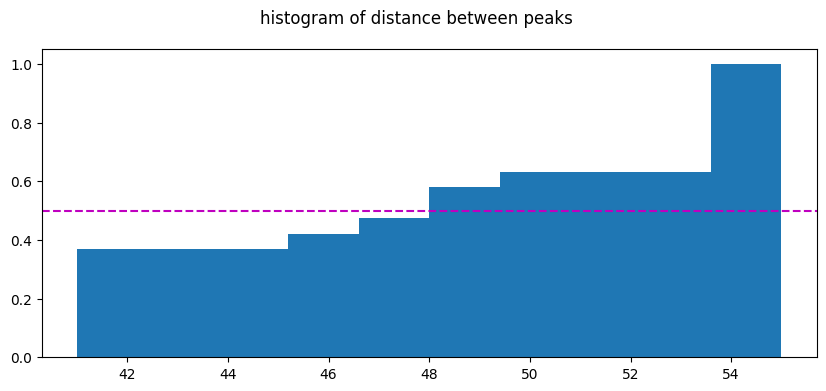

Mean Difference:  [48.]


In [150]:
fig,axs=plt.subplots(figsize=(10,4))
axs.hist(pd.DataFrame(peaks1).diff().dropna(),cumulative=True,density=True)
axs.axhline(y=.5,linestyle='--',color='m')
plt.suptitle('histogram of distance between peaks')
plt.show()
print('Mean Difference: ',pd.DataFrame(peaks1).diff().dropna().mean().values)

<li> The distance between peaks varies from roughly 41 to 55.
<li> The CDF value of .5 corresponds to roughly 48.
<br><p><i> 
<li> Hence the seasonality of logins can be considered to be 48 
<li> <b>Since each subsequent value is the login counts of 15 minutes, the actual seasonality = 15*48 = 720 minutes (12 hours)</b>
</i></p></br>